# Chapter 12: Least Squares Applications

## Concepts

In [196]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

In [197]:
# Gather Bike Rental Data

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"
data = pd.read_csv(url,sep=',',encoding='unicode_escape')

In [198]:
# Converting string columns to numbers
data["Seasons"].replace(["Spring", "Summer", "Autumn", "Winter"],[1,1,0,0], inplace=True)
data["Holiday"].replace(["Holiday", "No Holiday"],[1,0], inplace=True)
data["Functioning Day"].replace(["Yes", "No"],[1,0], inplace=True)

In [199]:
# EDA
data.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [200]:
# EDA
data.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,0.504110,0.049315,0.966324
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,0.500012,0.216537,0.180404
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,1.000000,0.000000,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,1.000000,1.000000,1.000000


{'Betas': {'Rainfall(mm)': -80.52367456202435, 'Seasons': 369.1266811234558, 'Intercept': 530.4945961502135}}


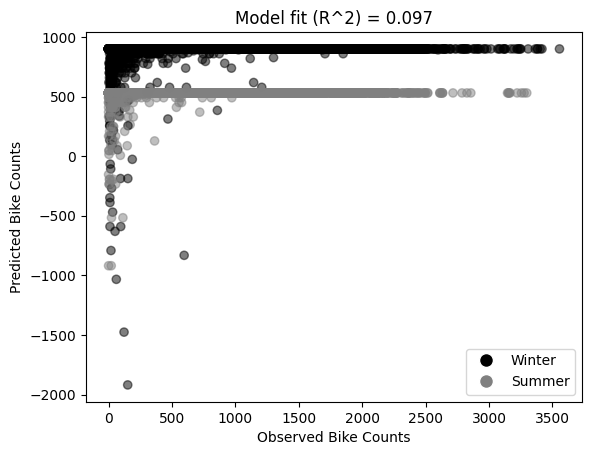

In [201]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in numpy


def fit_and_plot_bike_data(data, feature_columns, target_column, binary_feature=None, binary_labels=None):
    # Extract features and target variable
    features, target_variable = extract_features_and_target(data, feature_columns, target_column)
    
    # Add intercept
    design_matrix = add_intercept(features)
    
    # Fit least squares model
    betas = fit_least_squares(design_matrix, target_variable)
    
    # Print betas
    betas_dict = {feature_columns[i]: betas[i][0] for i in range(len(feature_columns))}
    betas_dict["Intercept"] = betas[-1][0]
    print({"Betas": betas_dict})
    
    # Make predictions
    predictions = design_matrix @ betas
    
    # Calculate R^2
    r2 = calculate_r2(target_variable, predictions)
    
    # Create colors for plot
    colors, binary_colors = create_colors(data, binary_feature, binary_labels)
    
    # Plot results
    plot_results(target_variable, predictions, colors, r2, binary_feature, binary_labels, binary_colors)

def extract_features_and_target(data, feature_columns, target_column):
    features = data[feature_columns].to_numpy()
    target_variable = data[[target_column]].to_numpy()
    return features, target_variable

def add_intercept(features):
    return np.append(features, np.ones(shape=(features.shape[0], 1)), axis=1)

def fit_least_squares(design_matrix, target_variable):
    results = np.linalg.lstsq(design_matrix, target_variable, rcond=None)
    betas = results[0]
    return betas

def calculate_r2(target_variable, predictions):
    ss_total = np.sum((target_variable - np.mean(target_variable)) ** 2)
    ss_residual = np.sum((target_variable - predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

def create_colors(data, binary_feature, binary_labels):
    if binary_feature and binary_labels:
        binary_colors = ["black", "grey"]
        colors = np.where(data[binary_feature].to_numpy() == 1, binary_colors[0], binary_colors[1])
        return colors, binary_colors
    else:
        return 'grey', None

def plot_results(target_variable, predictions, colors, r2, binary_feature, binary_labels, binary_colors):
    plt.scatter(target_variable, predictions, c=colors, alpha=0.5)
    plt.title(f'Model fit (R^2) = {round(r2, 3)}')
    plt.xlabel('Observed Bike Counts')
    plt.ylabel('Predicted Bike Counts')

    if binary_feature and binary_labels:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=binary_labels[0], markerfacecolor=binary_colors[0], markersize=10),
                           Line2D([0], [0], marker='o', color='w', label=binary_labels[1], markerfacecolor=binary_colors[1], markersize=10)]
        plt.legend(handles=legend_elements, loc='best')

    plt.show()

fit_and_plot_bike_data(
    data, 
    feature_columns=["Rainfall(mm)",  "Seasons"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

In [202]:
# Fit Bike Rental Data to Linear Regression model using Least Squares in statsmodels

# Create design matrix and target variable
design_matrix = data[["Rainfall(mm)",  "Seasons"]].copy()
target_variable = data[["Rented Bike Count"]].copy()

# Fit data using statsmodels OLS
design_matrix_ols = sm.add_constant(design_matrix)
model = sm.OLS(target_variable, design_matrix_ols).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     468.8
Date:                Mon, 27 May 2024   Prob (F-statistic):          3.80e-194
Time:                        09:34:28   Log-Likelihood:                -68654.
No. Observations:                8760   AIC:                         1.373e+05
Df Residuals:                    8757   BIC:                         1.373e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          530.4946      9.313     56.963   

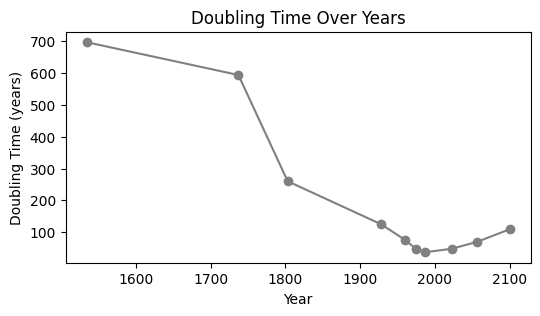

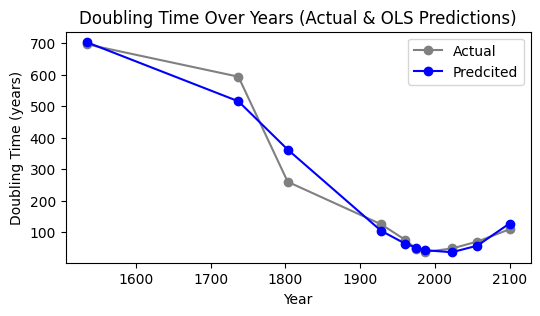

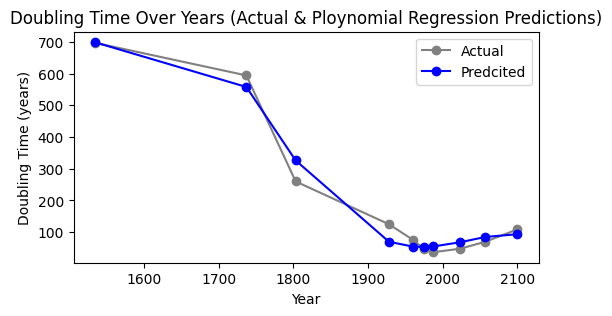

In [203]:
# Fit world population data using polynomial regression via numpy

# define data
year = [1534, 1737, 1803, 1928, 1960, 1975, 1987, 2023, 2057, 2100]
double_time = [697, 594, 260, 125, 76, 47, 37, 48, 70, 109]

# Plot data
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.title('Doubling Time Over Years')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.show()

# Perform Linear regression using numpy lstsq
design_matrix = np.zeros(shape=(10, 4))
for i in range(4):
    design_matrix[:, i] = np.array(year)**i

results = np.linalg.lstsq(design_matrix, double_time, rcond=None)
betas = results[0]

predictions = design_matrix @ betas

# Plot numpy lstsq results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & OLS Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

# Perform linear regression via numpy polyfit
betas = np.polyfit(year, double_time, deg=4)
predictions = np.polyval(betas, year)

# Plot numpy polyfit results
plt.figure(figsize=(6, 3))
plt.plot(year, double_time, marker='o', linestyle='-', color='grey')
plt.plot(year, predictions, marker='o', linestyle='-', color='blue')
plt.title('Doubling Time Over Years (Actual & Ploynomial Regression Predictions)')
plt.xlabel('Year')
plt.ylabel('Doubling Time (years)')
plt.legend(['Actual', 'Predcited'])
plt.show()

## Code Exercises

{'Betas': {'Rainfall(mm)': -9.829998229145021, 'Seasons': 48.42999142219219, 'Intercept': 152.11692428342974}}


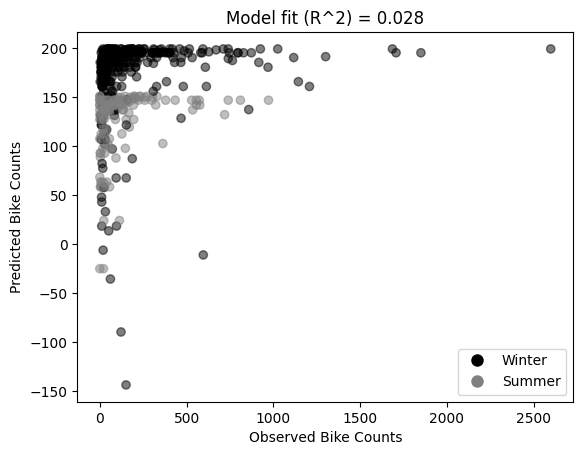

In [204]:
# Exercise 12-1 (Re-fit bike data after eliminating no rainfall instances)

no_rainfall_excluded = data[data['Rainfall(mm)'] != 0]

fit_and_plot_bike_data(
    no_rainfall_excluded, 
    feature_columns=["Rainfall(mm)",  "Seasons"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

{'Betas': {'Rainfall(mm)': -86.06170760812999, 'Temperature(°C)': 29.48981802920288, 'Intercept': 337.483293877251}}


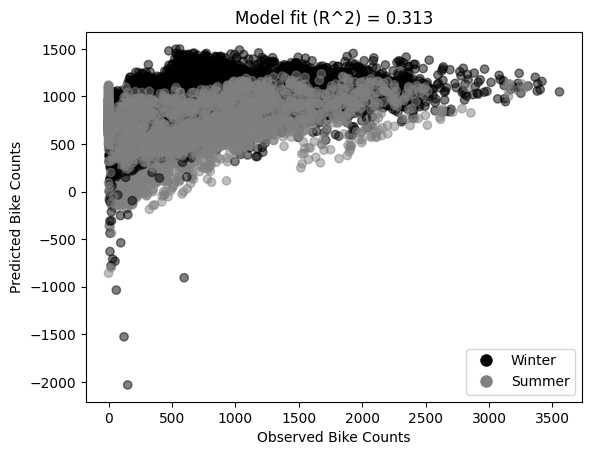

In [205]:
# Exercise 12-2 (Re-fit bike data after replacing seasons with temperature data)

fit_and_plot_bike_data(
    data, 
    feature_columns=["Rainfall(mm)",  "Temperature(°C)"], 
    target_column="Rented Bike Count", 
    binary_feature="Seasons", 
    binary_labels=["Winter", "Summer"]) 

In [225]:
# Exercise 12-3 (Re-fit bike data after creating new feature that is a linear combination of temperature and rainfall)

design_matrix = data[['Rainfall(mm)','Temperature(°C)']].to_numpy()
design_matrix = np.append(design_matrix, np.ones((design_matrix.shape[0],1)),axis=1)

modified_data = data.copy()
lincombo = 4 * design_matrix[:,0] + .4 * design_matrix[:,1]

# Create a design matrix
design_matrix_multicollinear = data[['Rainfall(mm)','Temperature(°C)']].to_numpy()
design_matrix_multicollinear = np.append(design_matrix_multicollinear, np.ones((design_matrix_multicollinear.shape[0],1)),axis=1)

# augmented design matrix
design_matrix_multicollinear = np.append(design_matrix_multicollinear,lincombo.reshape(-1,1),axis=1)
target_variable = modified_data[["Rented Bike Count"]].to_numpy()

print("Design Matrix Size:", design_matrix_multicollinear.shape)
print("Design Matrix Rank:", np.linalg.matrix_rank(design_matrix_multicollinear))
print("Design Matrix correlation matrix:", "\n", np.corrcoef(design_matrix_multicollinear.T), "\n")

# Left-inverse
design_matrix_leftinv = np.linalg.inv(design_matrix_multicollinear.T @ design_matrix_multicollinear) @ design_matrix_multicollinear.T
left_inverse_betas = design_matrix_leftinv @ target_variable
left_inverse_predictions = design_matrix_multicollinear @ left_inverse_betas
left_inverse_r2 = calculate_r2(target_variable, left_inverse_predictions)

# Numpy lstqr
results = np.linalg.lstsq(design_matrix_multicollinear, target_variable, rcond=None)
np_lstqr_betas = results[0]
np_lstqr_predictions = design_matrix_multicollinear @ np_lstqr_betas
np_lstqr_r2 = calculate_r2(target_variable, np_lstqr_predictions)

# Statsmodels
design_matrix_multicollinear_ols = sm.add_constant(design_matrix_multicollinear)
model = sm.OLS(target_variable, design_matrix_multicollinear_ols).fit()
statsmodels_betas = model.params
statsmodels_r2 = model.rsquared

print("MODEL FIT TO DATA:")
print("Left-inverse:", round(left_inverse_r2, 4))
print("np lstqr:", round(np_lstqr_r2, 4))
print("statsmodels:", round(statsmodels_r2, 4), "\n")

print("BETA COEFFICIENTS:")
print("Left-inverse:", np.around(left_inverse_betas.T, 2))
print("np lstqr:", np.around(np_lstqr_betas.T,  2))
print("statsmodels:", np.around(statsmodels_betas.T,  2))

Design Matrix Size: (8760, 4)
Design Matrix Rank: 3
Design Matrix correlation matrix: 
 [[1.         0.05028186        nan 0.70570444]
 [0.05028186 1.                nan 0.74309427]
 [       nan        nan        nan        nan]
 [0.70570444 0.74309427        nan 1.        ]] 

MODEL FIT TO DATA:
Left-inverse: -3.5341
np lstqr: 0.3126
statsmodels: 0.3126 

BETA COEFFICIENTS:
Left-inverse: [[-1.6707e+03 -1.1200e+00  3.3748e+02  1.1715e+02]]
np lstqr: [[ -8.57  37.24 337.48 -19.37]]
statsmodels: [ -8.57  37.24 337.48 -19.37]


inv(X'X + 0*I) size: (4, 4)
inv(X'X + 0*I) rank: 2 

inv(X'X + 0.01*I) size: (4, 4)
inv(X'X + 0.01*I) rank: 4 



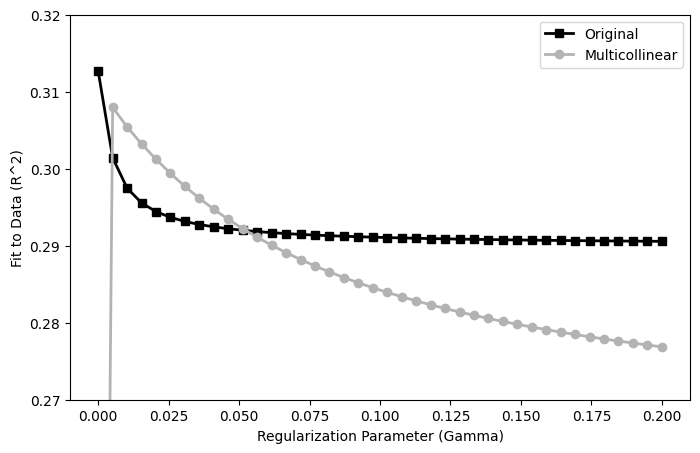

In [226]:
# Exercise 12-4 (Experiment with regularization effects on outcomes)

# Print left-inverse size & rank
def left_inverse_size_rank(design_matrix,  gamma):
    # regularization paramater multiplied by matrix frobenius norm
    gamnorm = gamma * np.linalg.norm(design_matrix,'fro')**2

    # inverse of (X'X+lI)
    leftinv = np.linalg.inv(design_matrix.T @ design_matrix + gamnorm * np.eye(design_matrix.shape[1]))
    print(f"inv(X'X + {gamma}*I) size: {leftinv.shape}")
    print(f"inv(X'X + {gamma}*I) rank: {np.linalg.matrix_rank(leftinv)}", "\n")

left_inverse_size_rank(design_matrix_multicollinear, gamma=0)
left_inverse_size_rank(design_matrix_multicollinear, gamma=0.01)

# Range of gamma parameters
gamma_values = np.linspace(0, 0.2, 40)

# Initialize R^2 vectors
r2_values = np.zeros(gamma_values.shape)
r2_multicollinear_values = np.zeros(gamma_values.shape)

# Loop over gamma values
for index in range(len(gamma_values)):
    gamma = gamma_values[index]

    # Regularization parameter for the original design matrix
    lambda_value = gamma * np.linalg.norm(design_matrix, 'fro')**2

    # Compute left-inverse for the original design matrix
    left_inverse = np.linalg.inv(design_matrix.T @ design_matrix + lambda_value * np.eye(design_matrix.shape[1])) @ design_matrix.T

    # Compute beta and predicted data for the original design matrix
    beta = left_inverse @ target_variable
    predictions = design_matrix @ beta

    # Model fit to data for the original design matrix
    r2_values[index] = np.corrcoef(target_variable.T, predictions.T)[0, 1]**2

    # Regularization parameter for the multicollinear design matrix
    lambda_multicollinear = gamma * np.linalg.norm(design_matrix_multicollinear, 'fro')**2

    # Compute left-inverse for the multicollinear design matrix
    left_inverse_multicollinear = np.linalg.inv(design_matrix_multicollinear.T @ design_matrix_multicollinear + lambda_multicollinear * np.eye(design_matrix_multicollinear.shape[1])) @ design_matrix_multicollinear.T

    # Compute beta and predicted data for the multicollinear design matrix
    beta_multicollinear = left_inverse_multicollinear @ target_variable
    predictions_multicollinear = design_matrix_multicollinear @ beta_multicollinear

    # Model fit to data for the multicollinear design matrix
    r2_multicollinear_values[index] = np.corrcoef(target_variable.T, predictions_multicollinear.T)[0, 1]**2

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, r2_values, 'ks-', linewidth=2, label='Original')  # Original in black squares
plt.plot(gamma_values, r2_multicollinear_values, 'o-', linewidth=2, label='Multicollinear', color=[0.7, 0.7, 0.7])  # Multicollinear in gray circles
plt.xlabel('Regularization Parameter (Gamma)')
plt.ylabel('Fit to Data (R^2)')
plt.ylim([0.27, 0.32])
plt.legend()
plt.show()

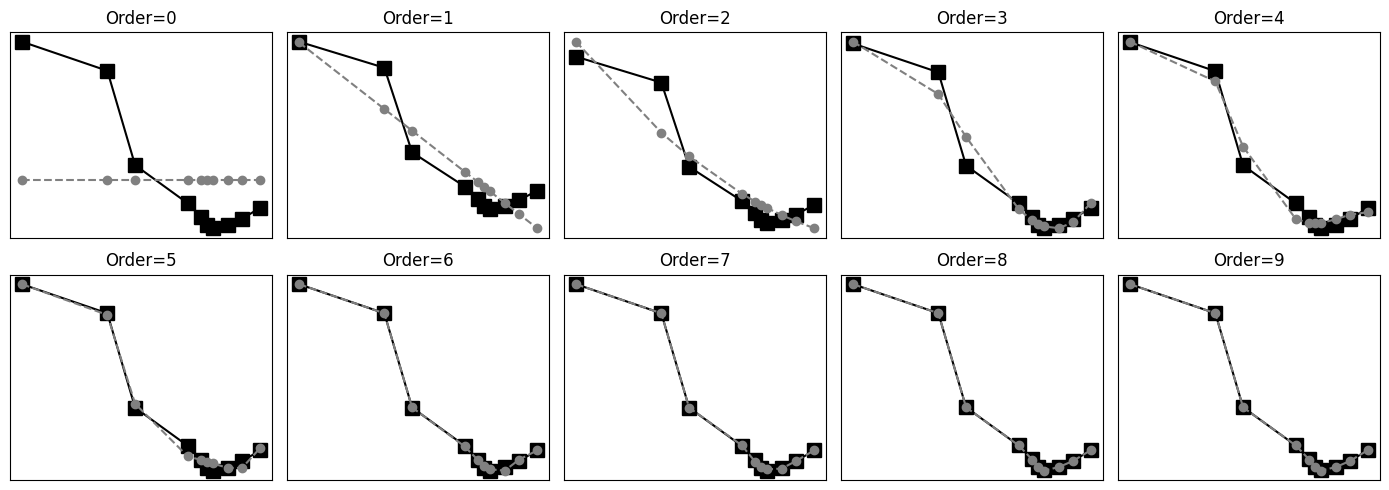

In [231]:
# Exercise 12-5 (Polynomial regression with varying orders)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(14, 5))
axes = axes.flatten()

# Loop over polynomial orders
for order_index in range(10):
    # Fit polynomial of given order
    polynomial_coefficients = np.polyfit(year, double_time, order_index)
    fitted_values = np.polyval(polynomial_coefficients, year)

    # Plot original data and fitted polynomial
    axes[order_index].plot(year, double_time, 'ks-', markersize=10)
    axes[order_index].plot(year, fitted_values, 'o--', color="grey")

    # Set plot parameters
    axes[order_index].set(xticks=[], yticks=[])
    axes[order_index].set_title(f'Order={order_index}')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


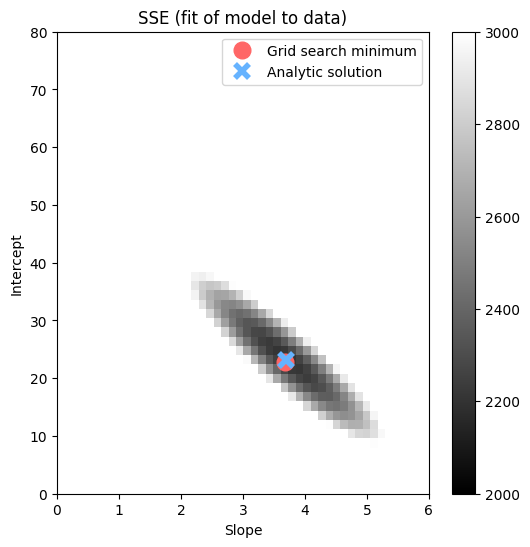

Analytic result:
Intercept: 23.13, slope: 3.70


Empirical result:
Intercept: 22.86, slope: 3.67


In [236]:
# Exercise 12-6 (Perform Grid Search to find parameters for Linear Regression)

# Data
number_of_courses = [13, 4, 12, 3, 14, 13, 12, 9, 11, 7, 13, 11, 9, 2, 5, 7, 10, 0, 9, 7]
happiness_levels = [70, 25, 54, 21, 80, 68, 84, 62, 57, 40, 60, 64, 45, 38, 51, 52, 58, 21, 75, 70]

# Design matrix
design_matrix = np.hstack((np.ones((20, 1)), np.array(number_of_courses, ndmin=2).T))
beta_coefficients = np.linalg.lstsq(design_matrix, happiness_levels, rcond=None)[0]

# Number of steps for each parameter
grid_resolution = 50

# Specify intercepts and slopes to test
intercept_values = np.linspace(0, 80, grid_resolution)
slope_values = np.linspace(0, 6, grid_resolution)

# Initialize output matrix for Sum of Squared Errors (SSE)
SSE_matrix = np.zeros((len(intercept_values), len(slope_values)))

# For-loops over parameters
for intercept_index in range(len(intercept_values)):
    for slope_index in range(len(slope_values)):

        # Model-predicted data
        predicted_happiness = design_matrix @ np.array([intercept_values[intercept_index], slope_values[slope_index]]).T

        # Sum of squared errors
        SSE_matrix[intercept_index, slope_index] = np.sum((predicted_happiness - happiness_levels) ** 2)

# Find empirical minimum
min_index_intercept, min_index_slope = np.unravel_index(np.argmin(SSE_matrix), SSE_matrix.shape)
empirical_intercept = intercept_values[min_index_intercept]
empirical_slope = slope_values[min_index_slope]

# Plot the error landscape with empirical minimum
plt.figure(figsize=(6, 6))
plt.imshow(SSE_matrix, vmin=2000, vmax=3000, extent=[slope_values[0], slope_values[-1], intercept_values[0], intercept_values[-1]],
           origin='lower', aspect='auto', cmap='gray')
plt.plot(empirical_slope, empirical_intercept, 'o', color=[1, 0.4, 0.4], markersize=12, label='Grid search minimum')
plt.plot(beta_coefficients[1], beta_coefficients[0], 'x', color=[0.4, 0.7, 1], markeredgewidth=4, markersize=10, label='Analytic solution')
plt.colorbar()
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('SSE (fit of model to data)')
plt.legend()
plt.show()

# Print out the results
print('Analytic result:')
print(f'Intercept: {beta_coefficients[0]:.2f}, slope: {beta_coefficients[1]:.2f}')
print('\n')
print('Empirical result:')
print(f'Intercept: {empirical_intercept:.2f}, slope: {empirical_slope:.2f}')


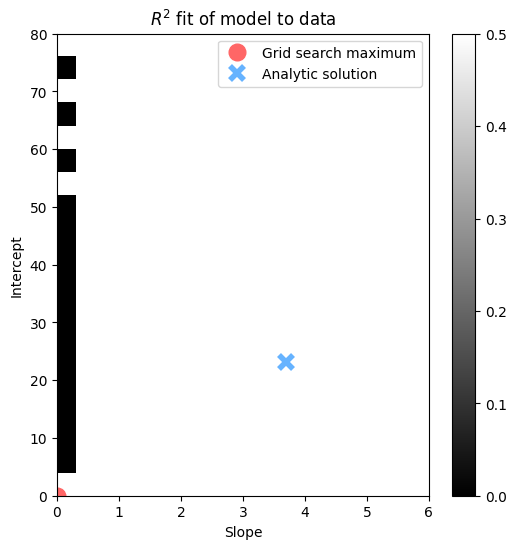

Analytic result:
Intercept: 23.13, slope: 3.70


Empirical result:
Intercept: 0.00, slope: 0.00


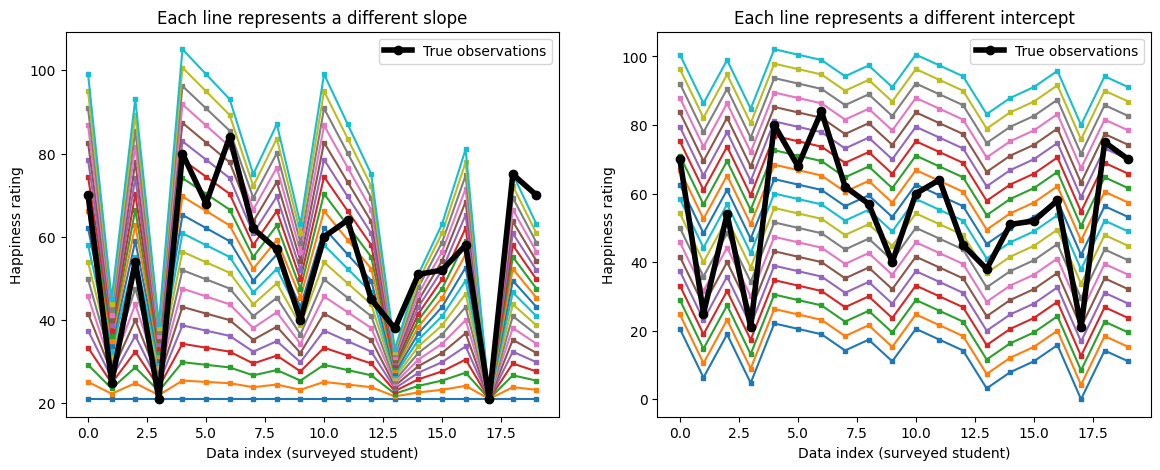

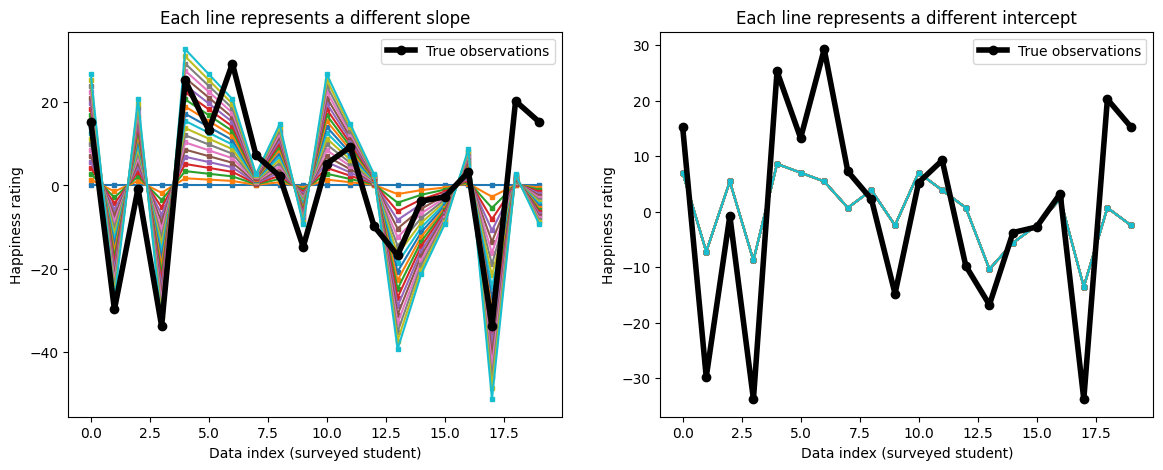

In [238]:
# Exercise 12-7 (Evaluating Linear Regression using R^2)

import numpy as np
import matplotlib.pyplot as plt

# Number of steps for each parameter
grid_resolution = 20

# Specify intercepts and slopes to test
intercept_values = np.linspace(0, 80, grid_resolution)
slope_values = np.linspace(0, 6, grid_resolution)

# Initialize output matrices
r2_values = np.zeros((len(intercept_values), len(slope_values)))
all_predicted_values = np.zeros((len(intercept_values), len(slope_values), len(happiness_levels)))

# For-loops over parameters
for intercept_index in range(len(intercept_values)):
    for slope_index in range(len(slope_values)):

        # Model-predicted data
        predicted_values = design_matrix @ np.array([intercept_values[intercept_index], slope_values[slope_index]]).T

        # R^2 model fit
        r2_values[intercept_index, slope_index] = np.corrcoef(predicted_values, happiness_levels)[0, 1]**2

        # Store all predicted data values
        all_predicted_values[intercept_index, slope_index, :] = predicted_values

# Find empirical maximum
max_r2_index_intercept, max_r2_index_slope = np.unravel_index(np.argmax(r2_values), r2_values.shape)
empirical_intercept = intercept_values[max_r2_index_intercept]
empirical_slope = slope_values[max_r2_index_slope]

# Plot the error landscape with empirical maximum
plt.figure(figsize=(6, 6))
plt.imshow(r2_values, vmin=0, vmax=0.5, extent=[slope_values[0], slope_values[-1], intercept_values[0], intercept_values[-1]],
           origin='lower', aspect='auto', cmap='gray')
plt.plot(empirical_slope, empirical_intercept, 'o', color=[1, 0.4, 0.4], markersize=12, label='Grid search maximum')
plt.plot(beta_coefficients[1], beta_coefficients[0], 'x', color=[0.4, 0.7, 1], markeredgewidth=4, markersize=10, label='Analytic solution')
plt.colorbar()
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('$R^2$ fit of model to data')
plt.legend()
plt.show()

# Print out the results
print('Analytic result:')
print(f'Intercept: {beta_coefficients[0]:.2f}, slope: {beta_coefficients[1]:.2f}')
print('\n')
print('Empirical result:')
print(f'Intercept: {empirical_intercept:.2f}, slope: {empirical_slope:.2f}')


# Plot predicted data for different parameters
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for different slopes
axes[0].plot(all_predicted_values[5, :, :].T, 's-', markersize=3)
axes[0].plot(happiness_levels, 'ko-', linewidth=4, label='True observations')
axes[0].set_xlabel('Data index (surveyed student)')
axes[0].set_ylabel('Happiness rating')
axes[0].set_title('Each line represents a different slope')
axes[0].legend()

# Plot for different intercepts
axes[1].plot(all_predicted_values[:, 5, :].T, 's-', markersize=3)
axes[1].plot(happiness_levels, 'ko-', linewidth=4, label='True observations')
axes[1].set_xlabel('Data index (surveyed student)')
axes[1].set_ylabel('Happiness rating')
axes[1].set_title('Each line represents a different intercept')
axes[1].legend()

plt.show()

# Plot mean-centered predicted data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Mean-centered plot for different slopes
axes[0].plot(all_predicted_values[5, :, :].T - np.mean(all_predicted_values[5, :, :].T, axis=0), 's-', markersize=3)
axes[0].plot(happiness_levels - np.mean(happiness_levels), 'ko-', linewidth=4, label='True observations')
axes[0].set_xlabel('Data index (surveyed student)')
axes[0].set_ylabel('Happiness rating')
axes[0].set_title('Each line represents a different slope')
axes[0].legend()

# Mean-centered plot for different intercepts
axes[1].plot(all_predicted_values[:, 5, :].T - np.mean(all_predicted_values[:, 5, :].T, axis=0), 's-', markersize=3)
axes[1].plot(happiness_levels - np.mean(happiness_levels), 'ko-', linewidth=4, label='True observations')
axes[1].set_xlabel('Data index (surveyed student)')
axes[1].set_ylabel('Happiness rating')
axes[1].set_title('Each line represents a different intercept')
axes[1].legend()

plt.show()

# Summary of findings:
# The predicted values are similar for different parameter pairs. 
# Mean-centering the data reveals that all intercept terms collapse into a single line,
# indicating that R^2 is not a useful model fit metric in this example.
# Carefully consider the metrics used to evaluate model fit to data.
